# Initialization

In this demo we are calling LLMs from OpenRouter, because with it you can access different LLM APIs from Hong Kong. But using the original OpenAIChatGenerator without overwritting the `api_base_url` would also work

In [ ]:
import os
from dotenv import load_dotenv
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.utils import Secret
from haystack.dataclasses import ChatMessage
from haystack.components.generators.utils import print_streaming_chunk

# Set your OpenRouter API key here. 
load_dotenv()
OPENROUTER_API_KEY = os.environ.get('OPENROUTER_API_KEY')

chat_generator = OpenAIChatGenerator(api_key=Secret.from_env_var("OPENROUTER_API_KEY"),
		api_base_url="https://openrouter.ai/api/v1",
		model="openai/gpt-4-turbo-preview",
        streaming_callback=print_streaming_chunk)

chat_generator.run(messages=[ChatMessage.from_user("Return this text: 'test'")])

# Step 1 - Establish data store

## Index Documents with a Pipeline
Here we provide sample texts for the model to perform Retrival Augmented Generation (RAG). The texts are turned into embeddings and stored in an in-memory document store

In [2]:
from haystack import Pipeline, Document
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

# Sample documents
documents = [
    Document(content="Coffee shop opens at 9am and closes at 5pm."),
    Document(content="Gym room opens at 6am and closes at 10pm.")
]

# Create the document store
document_store = InMemoryDocumentStore()

# Create a pipeline to turn the texts into embeddings and store them in the document store
indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    "doc_embedder", SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
)
indexing_pipeline.add_component("doc_writer", DocumentWriter(document_store=document_store))

indexing_pipeline.connect("doc_embedder.documents", "doc_writer.documents")

indexing_pipeline.run({"doc_embedder": {"documents": documents}})

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


{'doc_writer': {'documents_written': 2}}

## Spin up API server

An API server made with Flask is created under `db_api.py` to connect to SQLite. Please spin it up by running `python db_api.py` in your terminal 

# Step 2 - Define the functions
Here we prepare the actual functions for the model to invoke AFTER Function Calling. Function Calling provides ONLY the arguments for you to invoke these functions, it does not invoke the functions themselves

## RAG function
Namely the `rag_pipeline_func`. This is for the model to provide an answer by searching through the texts stored in the Document Store. We first define the RAG retrieval as a Haystack pipeline

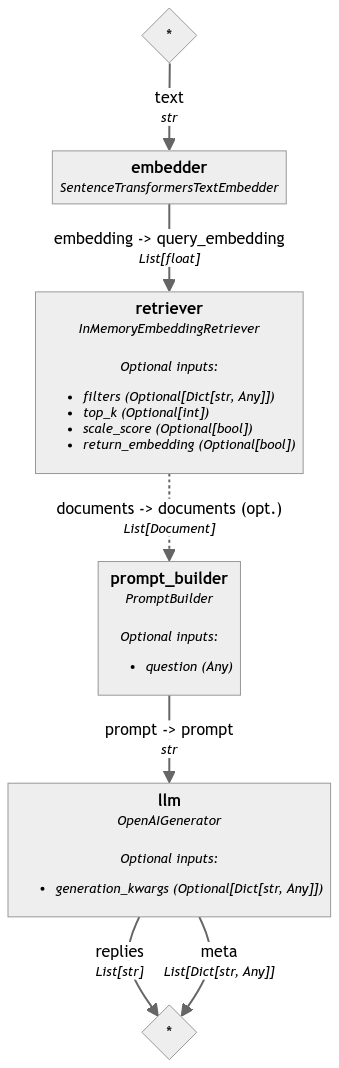

In [3]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

template = """
Answer the questions based on the given context.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}
Question: {{ question }}
Answer:
"""
rag_pipe = Pipeline()
rag_pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
rag_pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
rag_pipe.add_component("prompt_builder", PromptBuilder(template=template))
# Note to llm: We are using OpenAIGenerator, not the OpenAIChatGenerator, because the latter only accepts List[str] as input and cannot accept prompt_builder's str output
rag_pipe.add_component("llm", OpenAIGenerator(api_key=Secret.from_env_var("OPENROUTER_API_KEY"),
		api_base_url="https://openrouter.ai/api/v1",
		model="openai/gpt-4-turbo-preview"))

rag_pipe.connect("embedder.embedding", "retriever.query_embedding")
rag_pipe.connect("retriever", "prompt_builder.documents")
rag_pipe.connect("prompt_builder", "llm")

Test if the pipeline works

In [4]:
query = "When does the coffee shop open?"
rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

Batches: 100%|██████████| 1/1 [00:00<00:00, 63.95it/s]


{'llm': {'replies': ['The coffee shop opens at 9am.'],
  'meta': [{'model': 'openai/gpt-4-turbo-preview',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 9,
     'prompt_tokens': 60,
     'total_tokens': 69,
     'total_cost': 0.00087}}]}}

The pipeline is turned into a function

In [5]:
def rag_pipeline_func(query: str):
    result = rag_pipe.run({"embedder": {"text": query}, "prompt_builder": {"question": query}})

    return {"reply": result["llm"]["replies"][0]}

## API calls
For interacting with the API server, which in turns interact with our database

In [6]:
# Flask's default local URL, change it if necessary
db_base_url = 'http://127.0.0.1:5000'

# Use requests to get the data from the database
import requests
import json

def get_categories():
    response = requests.get(f'{db_base_url}/category')
    data = response.json()
    return data

def get_items(ids=None,categories=None):
    params = {
        'id': ids,
        'category': categories,
    }
    response = requests.get(f'{db_base_url}/item', params=params)
    data = response.json()
    return data

def purchase_item(id,quantity):

    headers = {
    'Content-type':'application/json', 
    'Accept':'application/json'
    }

    data = {
        'id': id,
        'quantity': quantity,
    }
    response = requests.post(f'{db_base_url}/item/purchase', json=data, headers=headers)
    return response.json()

## Define the tool list
Now that we have defined the fuctions, we need to let the model to recognize those functions, and to instruct them how they are used, by providing descriptions for them.

In [7]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_items",
            "description": "Get a list of items from the database",
            "parameters": {
                "type": "object",
                "properties": {
                    "ids": {
                        "type": "string",
                        "description": "Comma separated list of item ids to fetch",
                    },
                    "categories": {
                        "type": "string",
                        "description": "Comma separated list of item categories to fetch",
                    },
                },
                "required": [],
            },
        }
    },
    {
        "type": "function",
        "function": {
            "name": "purchase_item",
            "description": "Purchase a particular item",
            "parameters": {
                "type": "object",
                "properties": {
                    "id": {
                        "type": "string",
                        "description": "The given product ID, product name is not accepted here. Please obtain the product ID from the database first.",
                    },
                    "quantity": {
                        "type": "integer",
                        "description": "Number of items to purchase",
                    },
                },
                "required": [],
            },
        }
    },
    {
        "type": "function",
        "function": {
            "name": "rag_pipeline_func",
            "description": "Get information from hotel brochure",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
                    }
                },
                "required": ["query"],
            },
        },
    }
]

# Step 3: Putting it all together
We now have the necessary inputs to test Function Calling! Here we do a few things:
1. Provide the initial prompt to the model, to give it some context
2. Provide a sample user-generated message
3. Most importantly, we pass the tool list defined above to the chat generator in `tools`

In [15]:
# 1. Initial prompt
context = f"""You are an assistant to tourists visiting a hotel.
You have access to a database of items (which includes {get_categories()}) that tourists can buy, you also have access to the hotel's brochure.
If the tourist's question cannot be answered from the database, you can refer to the brochure.
If the tourist's question cannot be answered from the brochure, you can ask the tourist to ask the hotel staff.
"""
messages = [
    ChatMessage.from_system(context),
    # 2. Sample message from user
    ChatMessage.from_user("Can I buy a coffee?"),
    ]

# 3. Passing the tools list and invoke the chat generator
response = chat_generator.run(messages=messages, generation_kwargs= {"tools": tools})
response

{'replies': [ChatMessage(content='[{"index": 0, "id": "call_AkTWoiJzx5uJSgKW0WAI1yBB", "function": {"arguments": "{\\"categories\\":\\"Food and beverages\\"}", "name": "get_items"}, "type": "function"}]', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'openai/gpt-4-turbo-preview', 'index': 0, 'finish_reason': 'tool_calls', 'usage': {}})]}

Now let's inspect the response. Notice how the Function Calling returns both the function chosen by the model, and the arguments for invoking the chosen function.

In [9]:
function_call = json.loads(response["replies"][0].content)[0]
function_name = function_call["function"]["name"]
function_args = json.loads(function_call["function"]["arguments"])
print("Function Name:", function_name)
print("Function Arguments:", function_args)

Function Name: get_items
Function Arguments: {'categories': 'Food and beverages'}


When presented with another question, the model will use another tool that is more relevant

In [10]:
# Another question
messages.append(ChatMessage.from_user("Where's the coffee shop?"))

# Invoke the chat generator, and passing the tools list
response = chat_generator.run(messages=messages, generation_kwargs= {"tools": tools})
function_call = json.loads(response["replies"][0].content)[0]
function_name = function_call["function"]["name"]
function_args = json.loads(function_call["function"]["arguments"])
print("Function Name:", function_name)
print("Function Arguments:", function_args)

Function Name: rag_pipeline_func
Function Arguments: {'query': "Where's the coffee shop?"}


Notice that no actual function is invoked here, this is what we will do next

## Calling the function
We can then feed the arguments into the chosen function

In [11]:
## Find the correspoding function and call it with the given arguments
available_functions = {"get_items": get_items, "purchase_item": purchase_item,"rag_pipeline_func": rag_pipeline_func}
function_to_call = available_functions[function_name]
function_response = function_to_call(**function_args)
print("Function Response:", function_response)

Batches: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]


Function Response: {'reply': 'The provided context does not specify a physical location for the coffee shop, only its operating hours. Therefore, I cannot determine where the coffee shop is located based on the given information.'}


The response can then passed as a context to the chat, under the `messages` argument.

In [12]:
messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))
response = chat_generator.run(messages=messages)
response_msg = response["replies"][0]

print(response_msg.content)

For the location of the coffee shop within the hotel, I recommend asking the hotel staff directly. They will be able to guide you to it accurately.For the location of the coffee shop within the hotel, I recommend asking the hotel staff directly. They will be able to guide you to it accurately.


We now have completed the chat cycle!

## Turn into interactive chat
The below code is copied from [Haystack's tutorial](https://haystack.deepset.ai/tutorials/40_building_chat_application_with_function_calling). However, for interactive chat we better hook the model to Streamlit to provide a neat ChatGPT-like UI

In [ ]:
import json
from haystack.dataclasses import ChatMessage, ChatRole

response = None
messages = [
    ChatMessage.from_system(context)
]

while True:
    # if OpenAI response is a tool call
    if response and response["replies"][0].meta["finish_reason"] == "tool_calls":
        function_calls = json.loads(response["replies"][0].content)

        for function_call in function_calls:
            ## Parse function calling information
            function_name = function_call["function"]["name"]
            function_args = json.loads(function_call["function"]["arguments"])

            ## Find the correspoding function and call it with the given arguments
            function_to_call = available_functions[function_name]
            function_response = function_to_call(**function_args)

            ## Append function response to the messages list using `ChatMessage.from_function`
            messages.append(ChatMessage.from_function(content=json.dumps(function_response), name=function_name))

    # Regular Conversation
    else:
        # Append assistant messages to the messages list
        if not messages[-1].is_from(ChatRole.SYSTEM):
            messages.append(response["replies"][0])

        user_input = input("ENTER YOUR MESSAGE 👇 INFO: Type 'exit' or 'quit' to stop\n")
        if user_input.lower() == "exit" or user_input.lower() == "quit":
            break
        else:
            messages.append(ChatMessage.from_user(user_input))

    response = chat_generator.run(messages=messages, generation_kwargs={"tools": tools})